In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd as autograd   

import torch
import pandas as pd

from Residual_helper import interpolator_fvm

import sys
import os

# Add the path to the directory where Seq_Model_Parallel is located
module_path = os.path.abspath('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/')
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Plots')
if module_path not in sys.path:
    sys.path.append(module_path)


# from Plot_helper_Oct2024 import plot3D_comp2

device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print("Device 1: ",device1)
print("Device 2: ",device2)

Device 1:  cuda:2
Device 2:  cuda:3


In [2]:
folder_main = '/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/PINN_AFSD/Code_Final_Sept2024/AFSD_PINN/Models_Trained/'
# filename = 'AFSD_Exp_900rpm_2mms.pt'
filename = 'AFSD_Linear_300.pt'
data_filename = 'Linear_300_2mms'

R0 = 5 #mm 5.34
Rs = 19 #mm
mu_vis = 0.3 
mu = 0.3 #Friction Coefficient (not viscosity)
delta = 0.5
A = 6.41 #For slip factor
pi = np.pi

Omega = 300 #rpm
V = 2 #mm/s


F = 0.67 #mm
rho = 2700 * 1e-6 #g/mm3
k_B = 1.380649*1e-23 #J/K
R = 8.314 #J/(K.mol)
E_a = 205000 #J/mol #Q
alpha_sig = 52 #mm^2/N
# A = np.exp(27.78)
log_A = 27.78
n = 3.49
k = 0.167 #Thermal Conductivity #W/(mmK)
c_p = 0.897 #J/gK 
alpha_m = k/(rho*c_p)
T_a = 298.0


k_t = 0.0176 #W/(mmK)
c_p_t = 0.46 #J/gk
rho_t = 2700 * 1e-6 #g/mm3
alpha_t = k_t/(rho_t*c_p_t)

h_sides = 5*1e-6 #W/mm^2K
C_bot = 0.15*1e-6 #W/mm^2K^3

eeta = alpha_m/(alpha_m+alpha_t)

lb_xyz_uvw = np.array([-20.0,-20.0,-3.0])
ub_xyz_uvw = np.array([20.0,20.0,0.0])


lb_xyz = np.array([-50.0,-20.0,-3.0])
ub_xyz = np.array([50.0,20.0,0.0])



In [3]:
from Seq_Model_Parallel import coupled_PINN

layers1 = np.array([3,50,50,50,4]) #9 hidden layers
layers2 = np.array([3,50,50,50,1]) #9 hidden layers
# layers = np.array([3,50,50,50,5])
# layers = np.array([3,64,64,64,1])
model_PINN = coupled_PINN(layers1,layers2,device1,device2,lb_xyz,ub_xyz)

model_PINN.load_state_dict(torch.load(folder_main + filename))

#Testing with FVM data
fvm_data = loadmat('/home/smartlab/Documents/jupyterNB/raghav/Projects_git_summer2024/Data/AFSD_Nikhil/' + data_filename)

u_fvm = fvm_data['u_star']
v_fvm = fvm_data['v_star']
w_fvm = fvm_data['w_star']
p_fvm = fvm_data['p_star']
u_cfvm = (u_fvm[0:-1,:,:] + u_fvm[1:,:,:])/2
v_cfvm = (v_fvm[:,0:-1,:] + v_fvm[:,1:,:])/2
w_cfvm = (w_fvm[:,:,0:-1] + w_fvm[:,:,1:])/2

# Res_v_fvm = np.sqrt(np.square(u_fvm) + np.square(v_fvm) + np.square(w_fvm))
T_fvm = fvm_data['T']
sigma_e_fvm = fvm_data['effectivestress']
eps_e_fvm = fvm_data['effstrrate']
mu_vis_fvm = fvm_data['mu']

Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=4, bias=True)
  )
)
Sequentialmodel(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)


/home/smartlab/anaconda3/envs/raghav/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
fvm_data = {"T_fvm": T_fvm,"u_fvm": u_fvm,"v_fvm": v_fvm,"w_fvm": w_fvm, "sigma_e_fvm": sigma_e_fvm, "eps_e_fvm": eps_e_fvm,
            "mu_vis_fvm": mu_vis_fvm}

heat_mat_props = {"k": k,"rho": rho,"c_p": c_p}


In [ ]:


from Cont_Eq_Residuals import rmse_cont_res_fvm_pinn

rmse_res_fvm, rmse_res_PINN = rmse_cont_res_fvm_pinn(lb_xyz,ub_xyz,fvm_data, heat_mat_props, model_PINN)
print("RMSE residuals for FVM: ", rmse_res_fvm)
print("RMSE residuals for PINN: ", rmse_res_PINN)

Interpolation Done...
Interpolation Done...
Interpolation Done...
RMSE residuals for FVM:  0.4891412037020355
RMSE residuals for PINN:  2.3540924


In [7]:
from Heat_Eq_Residuals import rmse_heat_res_fvm_pinn

rmse_res_fvm, rmse_res_PINN = rmse_heat_res_fvm_pinn(lb_xyz,ub_xyz,fvm_data, heat_mat_props, model_PINN)

print("RMSE residuals for FVM: ", rmse_res_fvm)
print("RMSE residuals for PINN: ", rmse_res_PINN)

Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
RMSE residuals for FVM:  820609042.865056
RMSE residuals for PINN:  1.3735254


RMSE residuals for FVM:  324380453.10890436
RMSE residuals for PINN:  2.7784734


Interpolation Done...
Interpolation Done...
Interpolation Done...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 2; 10.76 GiB total capacity; 9.98 GiB already allocated; 19.81 MiB free; 9.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

RMSE residuals for FVM:  324380453.10890436
RMSE residuals for PINN:  2.7784734


In [4]:
#Heat Equation Residuals

#f5 = kT_xx + kT_yy + kT_zz - q_g.reshape(-1,) - (rho*c_p)*(uT_x + vT_y + wT_z)

main_dim = 0
opt = 'neutral'

#LHS
data = T_fvm
nu_s = [[2,0,0],[0,2,0],[0,0,2]]
outputs = interpolator_fvm(data,main_dim,opt,lb_xyz,ub_xyz,nu_s)

T_xx_fvm = outputs[0]
T_yy_fvm = outputs[1]
T_zz_fvm = outputs[2]

#Q_G 
data_2 = [sigma_e_fvm,eps_e_fvm]
terms2 = []
for data in data_2:
    nu_s = [None]
    outputs = interpolator_fvm(data,main_dim,opt,lb_xyz,ub_xyz,nu_s)
    terms2.append(outputs)

sigma_e_interp = terms2[0][0]
eps_e_interp = terms2[1][0]

q_g_fvm = 0.9*sigma_e_interp*eps_e_interp

#RHS

u_cfvm = interpolator_fvm(u_fvm,main_dim = 1,opt = 'grid',lb_xyz=lb_xyz,ub_xyz=ub_xyz,nu_s=[[0,0,0]])[0]
v_cfvm = interpolator_fvm(v_fvm,main_dim = 2,opt = 'grid',lb_xyz=lb_xyz,ub_xyz=ub_xyz,nu_s=[[0,0,0]])[0]
w_cfvm = interpolator_fvm(w_fvm,main_dim = 3,opt = 'grid',lb_xyz=lb_xyz,ub_xyz=ub_xyz,nu_s=[[0,0,0]])[0]

data_3 = [u_cfvm*T_fvm,v_cfvm*T_fvm,w_cfvm*T_fvm]

nu_s_3 = [[[1,0,0]],[[0,1,0]],[[0,0,1]]]
terms_3 = []


for i in range(3):
    data = data_3[i]   
    nu_s =nu_s_3[i]
    outputs = interpolator_fvm(data,main_dim,opt,lb_xyz,ub_xyz,nu_s)
    terms_3.append(outputs)

uT_x_fvm = terms_3[0][0]
vT_y_fvm= terms_3[1][0]
wT_z_fvm = terms_3[2][0]


Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...
Interpolation Done...


In [5]:
residuals_fvm = k*(T_xx_fvm + T_yy_fvm + T_zz_fvm) - q_g_fvm - rho*c_p*(uT_x_fvm + vT_y_fvm + wT_z_fvm)
np.sqrt(np.mean(np.square(residuals_fvm)))

264414917.03846806

In [6]:
# f1 = rho*(u2_x + uv_xyz[:,1] + uw_xyz[:,2]) + p_xyz[:,0] - 2*u_x_xyz[:,0] - (v_x_xyz[:,1] + u_y_xyz[:,1]) - (w_x_xyz[:,2] + u_z_xyz[:,2]) 
# f2 = rho*(uv_xyz[:,0] + v2_y + vw_xyz[:,2]) + p_xyz[:,1] - (u_y_xyz[:,0] + v_x_xyz[:,0]) - 2*v_y_xyz[:,1]  - (w_y_xyz[:,2] + v_z_xyz[:,2])
# f3 = rho*(uw_xyz[:,0] + vw_xyz[:,1] + w2_z) + p_xyz[:,2] - (u_z_xyz[:,0] + w_x_xyz[:,0]) - (v_z_xyz[:,1] + w_y_xyz[:,1]) - 2*w_z_xyz[:,2])


# opt = 'grid'

# #f1
# #group1
# uv_cfvm = u_cfvm*v_cfvm
# vw_cfvm = v_cfvm*w_cfvm

# data_3 = [u_fvm*u_fvm,uv_cfvm,vw_cfvm]

# nu_s_3 = [[[1,0,0]],[[0,1,0]],[[0,0,1]]]
# terms_3 = []
# main_dims = [1,0,0]


# for i in range(3):
#     data = data_3[i]   
#     nu_s =nu_s_3[i]
#     outputs = interpolator_fvm(data,main_dims[i],opt,lb_xyz,ub_xyz,nu_s)
#     terms_3.append(outputs)



# #Q_G 
# data_2 = [sigma_e_fvm,eps_e_fvm]
# terms2 = []
# for data in data_2:
#     nu_s = [None]
#     outputs = interpolator_fvm(data,main_dim,opt,lb_xyz,ub_xyz,nu_s)
#     terms2.append(outputs)

# sigma_e_interp = terms2[0][0]
# eps_e_interp = terms2[1][0]

# q_g_fvm = 0.9*sigma_e_interp*eps_e_interp

# #RHS
# data_3 = [u_cfvm*T_fvm,v_cfvm*T_fvm,w_cfvm*T_fvm]

# nu_s_3 = [[[1,0,0]],[[0,1,0]],[[0,0,1]]]
# terms_3 = []


# for i in range(3):
#     data = data_3[i]   
#     nu_s =nu_s_3[i]
#     outputs = interpolator_fvm(data,main_dim,opt,lb_xyz,ub_xyz,nu_s)
#     terms_3.append(outputs)

# uT_x_fvm = terms_3[0][0]
# vT_y_fvm= terms_3[1][0]
# wT_z_fvm = terms_3[2][0]

In [7]:
residuals_fvm = k*(T_xx_fvm + T_yy_fvm + T_zz_fvm) - q_g_fvm - rho*c_p*(uT_x_fvm + vT_y_fvm + wT_z_fvm)
np.sqrt(np.mean(np.square(residuals_fvm)))

264414917.03846806

In [8]:
#np.sum(np.abs(residuals)<100)/(100*100*10)

In [9]:
np.min(np.log10(np.abs(residuals)))

NameError: name 'residuals' is not defined

In [10]:
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

# x_min = -20.0
# x_max = 20.0

# x = np.linspace(x_min,x_max,250)
x = np.linspace(x_min,x_max,251)
x = (x[0:-1] + x[1:]).reshape(-1,1)/2
y = np.linspace(y_min,y_max,251)
y = (y[0:-1] + y[1:]).reshape(-1,1)/2
z = np.linspace(z_min,z_max,13)
z = (z[0:-1] + z[1:]).reshape(-1,1)/2

X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float()
# uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()

# Res_v_PINN = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))

In [11]:
#looping to save memory (overall 100000 neutral points)
g = xyz_test_tensor[:10000,:].clone()
g.requires_grad = True
residuals_PINN = model_PINN.helper_gradients(g,ind = 2)

In [13]:
residuals_PINN.shape

torch.Size([10000])

In [ ]:
# residuals_PINN = residuals_PINN.reshape(100,100).cpu().detach().numpy()

In [21]:
np.mean(np.square(residuals_PINN))

0.043636348

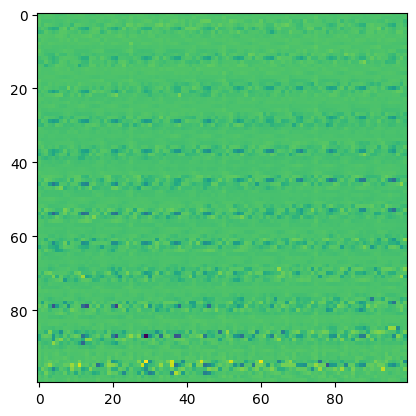

In [14]:
plt.imshow(residuals_PINN[:,:,1])

In [8]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).to(device2)
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)) #.to(device2)

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to(device2),retain_graph=True,allow_unused = True)[0]
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to(device2),retain_graph=True,allow_unused = True)[0]
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to(device2),retain_graph=True,allow_unused = True)[0]

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)
q_g = 0.9*sigma_e*eps_e

T_xyz = autograd.grad(T,g,torch.ones([g.shape[0], 1]), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
T_x = T_xyz[:,0:1]
T_y = T_xyz[:,1:2]
T_z = T_xyz[:,2:3]

T_x_xyz = autograd.grad(T_x,g,torch.ones([g.shape[0], 1]).to(device2), retain_graph=True, create_graph=True,allow_unused = True)[0]
T_y_xyz = autograd.grad(T_y,g,torch.ones([g.shape[0], 1]).to(device2), retain_graph=True, create_graph=True,allow_unused = True)[0]
T_z_xyz = autograd.grad(T_z,g,torch.ones([g.shape[0], 1]).to(device2), retain_graph=True, create_graph=True,allow_unused = True)[0]

kT_xx = k*T_x_xyz[:,0]
kT_yy = k*T_y_xyz[:,1]
kT_zz = k*T_z_xyz[:,2]

uT_x = autograd.grad(u*T,g,torch.ones([g.shape[0], 1]).to(device2), retain_graph=True, create_graph=True,allow_unused = True)[0][:,0]
vT_y = autograd.grad(v*T,g,torch.ones([g.shape[0], 1]).to(device2), retain_graph=True, create_graph=True,allow_unused = True)[0][:,1]
wT_z = autograd.grad(w*T,g,torch.ones([g.shape[0], 1]).to(device2), retain_graph=True, create_graph=True,allow_unused = True)[0][:,2]

# f5 = kT_xx + kT_yy + kT_zz + q_g.reshape(-1,)/(rho*c_p) - (rho*c_p)*(uT_x + vT_y + wT_z)

f5 = kT_xx + kT_yy + kT_zz - q_g.reshape(-1,) - (rho*c_p)*(uT_x + vT_y + wT_z)

T = T.cpu().detach().numpy()
eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cuda:3!

In [10]:
def RMSE(a,b):
    return np.sqrt(np.mean(np.square(a-b)))

def RE(a_true,a):
    return np.linalg.norm((a_true-a).reshape(-1,),2)/np.linalg.norm(a_true.reshape(-1,),2)

def corr(a,b):
    return np.corrcoef(a.reshape(-1,),b.reshape(-1,))[0,1]


def correct_shape(a):
    a = a.reshape(12,250,100,order = 'C')
    return np.swapaxes(np.swapaxes(a,0,1),1,2)

def print_metrics(a,b,name):
    print(name+" :","RMSE ",RMSE(a.reshape(-1,),b.reshape(-1,)))
    print(name+" :","RE ", RE(a.reshape(-1,),b.reshape(-1,)))
    print(name+" :","Corr ", corr(a.reshape(-1,),b.reshape(-1,)))


T = correct_shape(T)
eps_e = correct_shape(eps_e)
sigma_e = correct_shape(sigma_e)
mu_vis = correct_shape(mu_vis)
Res_v_PINN = correct_shape(Res_v_PINN)
# mu_vis = correct_shape(mu_vis)

In [11]:
print_metrics(T_fvm,T,"T")
print_metrics(eps_e_fvm,eps_e,"Eps")
print_metrics(sigma_e_fvm,sigma_e,"Sigma")
print_metrics(Res_v_fvm,Res_v_PINN/1000,"Res V")
print_metrics(mu_vis_fvm,mu_vis,"Mu Vis")

T : RMSE  34.852819629036006
T : RE  0.06445561515207361
T : Corr  0.963521740800689
Eps : RMSE  39.859635932196376
Eps : RE  6.877060834054943
Eps : Corr  0.9063101756887072
Sigma : RMSE  85860637.08086942
Sigma : RE  0.999999998673783
Sigma : Corr  0.43335352064933447
Res V : RMSE  0.005415601581138398
Res V : RE  0.4243653317782019
Res V : Corr  0.8898616924693851
Mu Vis : RMSE  81857949655.92343
Mu Vis : RE  0.9999999999997797
Mu Vis : Corr  0.46184627433493614


In [12]:
# PLOTTING
[x_min,y_min,z_min] = lb_xyz
[x_max,y_max,z_max] = ub_xyz

x_min = -8.0
x_max = 8.0



x = np.linspace(x_min,x_max,17).reshape(-1,1)
# y = np.linspace(y_min,y_max,200).reshape(-1,1)
y = 20.0
z = np.linspace(z_min,z_max,5).reshape(-1,1)
# z = -0.4
X,Y,Z = np.meshgrid(x,y,z)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
Z = Z.flatten('F').reshape(-1,1)

xyz = np.hstack((X,Y,Z))
xyz_test_tensor = torch.from_numpy(xyz).float().to(device1)

uvwp = model_PINN.PINN_uvw.forward(xyz_test_tensor).cpu().detach().numpy()
T = model_PINN.PINN_T.forward(xyz_test_tensor.to(device2)).cpu().detach().numpy()

In [13]:
T = T.reshape(5,17)

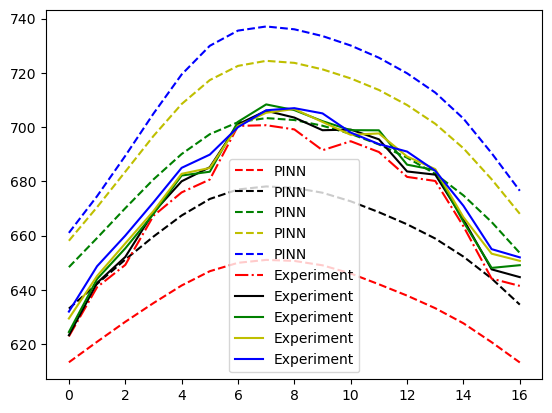

In [17]:
p_base = 26
fig,ax = plt.subplots()
ax.plot(np.flip(T[0,:]),'r--',label='PINN')
ax.plot(np.flip(T[1,:]),'k--',label='PINN')
ax.plot(np.flip(T[2,:]),'g--',label='PINN')
ax.plot(np.flip(T[3,:]),'y--',label='PINN')
ax.plot(np.flip(T[4,:]),'b--',label='PINN')



ax.plot(data_exp_300_2mms[:,p_base+4],'r-.',label = 'Experiment')
ax.plot(data_exp_300_2mms[:,p_base+3],'k',label = 'Experiment')
ax.plot(data_exp_300_2mms[:,p_base+2],'g',label = 'Experiment')
ax.plot(data_exp_300_2mms[:,p_base+1],'y',label = 'Experiment')
ax.plot(data_exp_300_2mms[:,p_base],'b',label = 'Experiment')
ax.legend()

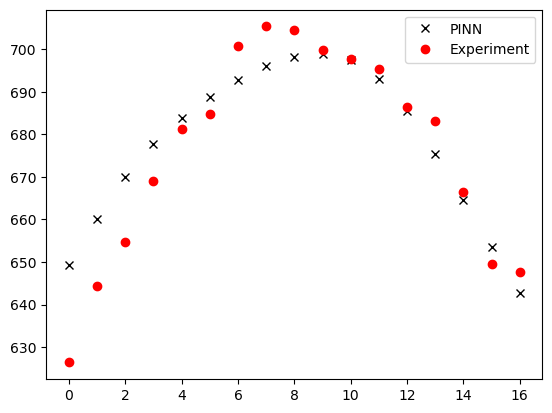

In [119]:
p_base = 26
fig,ax = plt.subplots()
ax.plot(np.mean(T,axis = 0),'kx',label='PINN')
ax.plot(np.mean(data_exp_300_2mms[:,p_base:p_base+5],axis = 1),'ro',label = 'Experiment')



# ax.plot(data_exp_300_2mms[:,p_base+4],'r-.',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base+3],'k',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base+2],'g',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base+1],'y',label = 'Experiment')
# ax.plot(data_exp_300_2mms[:,p_base],'b',label = 'Experiment')
ax.legend()

In [66]:
#Tracing Points
xyz_start = np.array([0.0,0.0,-0.01])

n_timesteps = 2000




xyz_trace = np.zeros((n_timesteps+1,3))
eps_e_trace = np.zeros((n_timesteps))

xyz_trace[0] = xyz_start 
xyz = xyz_trace[0]

for t in range(n_timesteps):
    xyz_tensor = torch.from_numpy(xyz).float().to(device1)
    uvwp = model_PINN.PINN_uvw.forward(xyz_tensor).cpu().detach().numpy()

    dx = uvwp[0]/10000.0
    dy = uvwp[1]/10000.0
    dz = uvwp[2]/10000.0
    
    xyz = xyz + np.array([dx,dy,dz])


    g = xyz_tensor.reshape(1,-1).clone()
    g.requires_grad = True

    out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
    u = out_full[:,0:1]
    v = out_full[:,1:2]
    w = out_full[:,2:3]
    p = out_full[:,3:4]


    # print(T.shape)
    T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

    # print(u.shape)
    [ront]

    # p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
    u_xyz = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
    v_xyz = autograd.grad(v,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
    w_xyz = autograd.grad(w,g,torch.ones([g.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

    eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
    eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
    eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

    eps2_21 = eps2_12
    eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
    eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

    eps2_31 = eps2_13
    eps2_32 = eps2_23 
    eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

    eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)

    eps_e_trace[t] = eps_e

    xyz_trace[t+1,:] = xyz

KeyboardInterrupt: 

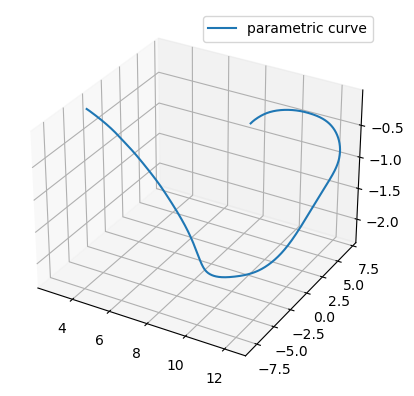

In [162]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xyz_trace[:,0], xyz_trace[:,1], xyz_trace[:,2], label='parametric curve')
ax.legend()

plt.show()

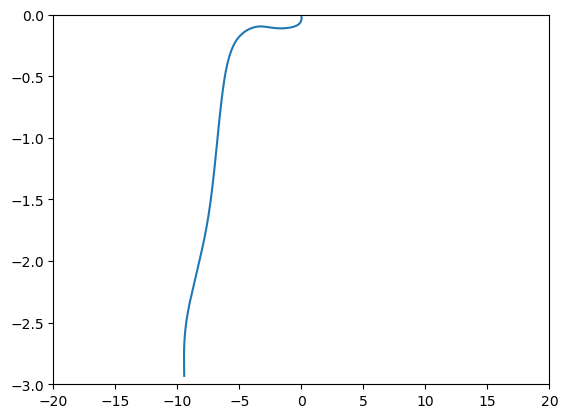

In [166]:
fig,ax = plt.subplots()
ax.plot(xyz_trace[:,0], xyz_trace[:,2], label='parametric curve')
ax.set_xlim([-20,20])
ax.set_ylim([-3.0,0.0])
# ax.set_ylim([-20,20])
# ax.legend()

plt.show()

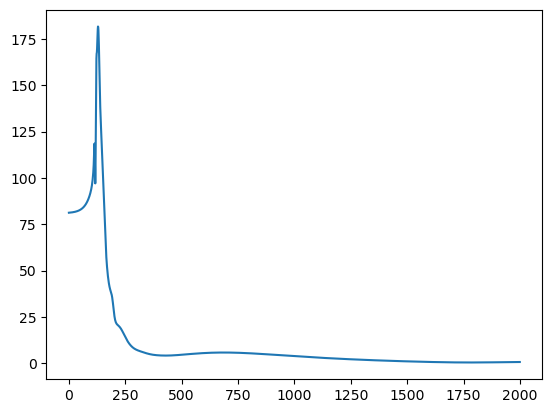

In [167]:
plt.plot(eps_e_trace)

In [154]:
z.shape

(100,)

In [155]:
# g = xyz_test_tensor.clone()
# g.requires_grad = True

# out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
# u = out_full[:,0:1]
# v = out_full[:,1:2]
# w = out_full[:,2:3]
# p = out_full[:,3:4]


# # print(T.shape)
# T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# # p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
# u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
# v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
# w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

# eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
# eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
# eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

# eps2_21 = eps2_12
# eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
# eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

# eps2_31 = eps2_13
# eps2_32 = eps2_23 
# eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

# eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# # Z = eps_e*torch.exp(E_a/(R*T))
# # log_Z = torch.log(eps_e) + E_a/(R*T)
# log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


# W = (log_Z - log_A)/n



# # sigma_e =  (1/alpha_sig)*torch.asinh(W) 
# sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

# #____________________________#
# mu_vis = sigma_e/(3*eps_e)

# T = T.cpu().detach().numpy()
# eps_e = eps_e.cpu().detach().numpy()
# sigma_e = sigma_e.cpu().detach().numpy()
# mu_vis = mu_vis.cpu().detach().numpy()

ValueError: cannot reshape array of size 10000 into shape (200,200)

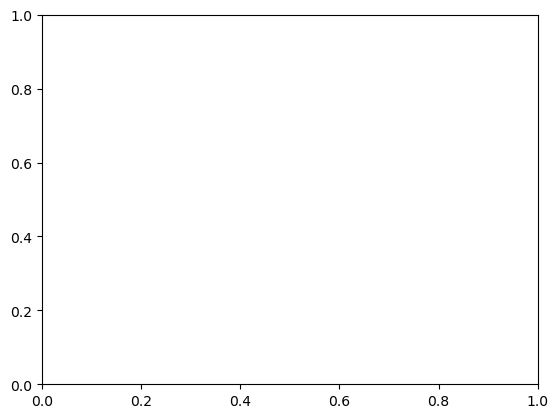

In [20]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((r_vel/1000).reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$y$ (mm)')

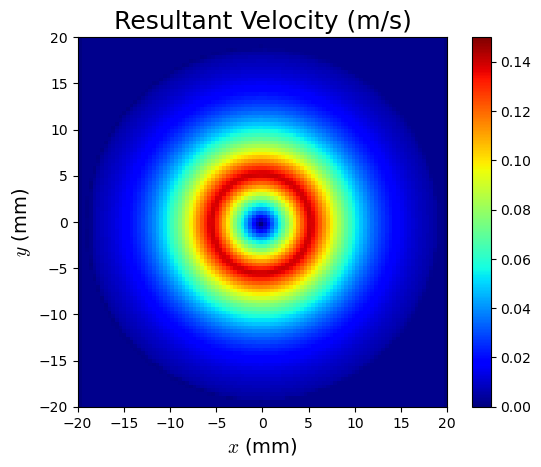

In [21]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(Res_v_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 0.15,vmin = 0)
fig.colorbar(im)
ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

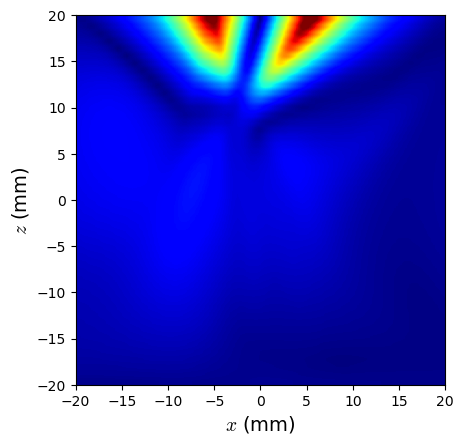

In [23]:
r_vel = np.sqrt(np.square(uvwp[:,0])+np.square(uvwp[:,1])+np.square(uvwp[:,2]))
# r_vel = np.sqrt(np.square(uvwp[:,2]))
# r_vel = uvwp[:,2]
fig,ax = plt.subplots()
im = ax.imshow((np.flip(r_vel)/1000).reshape(50,200),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Res_vel_PureSlip_xz.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

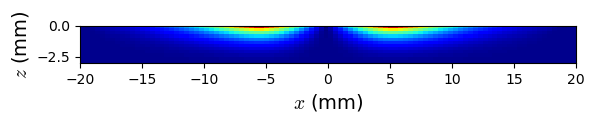

In [24]:
#FVM
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(Res_v_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 0.15,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('FVM_Res_vel_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

In [25]:
g = xyz_test_tensor.clone()
g.requires_grad = True

out_full = model_PINN.PINN_uvw.forward(g.to(device1)).cpu() 
u = out_full[:,0:1]
v = out_full[:,1:2]
w = out_full[:,2:3]
p = out_full[:,3:4]


# print(T.shape)
T = model_PINN.PINN_T.forward(g.to(device2)).cpu()

# p_xyz = autograd.grad(p,g,torch.ones([xyz_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
u_xyz = autograd.grad(u,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
v_xyz = autograd.grad(v,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()
w_xyz = autograd.grad(w,g,torch.ones([xyz_test_tensor.shape[0], 1]).to('cpu'),retain_graph=True,allow_unused = True)[0].cpu()

eps2_11 = torch.square(1/2*(2*u_xyz[:,0]))
eps2_12 = torch.square(1/2*(u_xyz[:,1] + v_xyz[:,0]))
eps2_13 = torch.square(1/2*(u_xyz[:,2] + w_xyz[:,0]))

eps2_21 = eps2_12
eps2_22 = torch.square(1/2*(2*v_xyz[:,1])) 
eps2_23 = torch.square(1/2*(v_xyz[:,2] + w_xyz[:,1]))

eps2_31 = eps2_13
eps2_32 = eps2_23 
eps2_33 = torch.square(1/2*(2*w_xyz[:,2]))

eps_e = torch.sqrt((2/3)*(eps2_11 + eps2_12 + eps2_13 + eps2_21 + eps2_22 + eps2_23 + eps2_31 + eps2_32 + eps2_33)).reshape(-1,1)


# Z = eps_e*torch.exp(E_a/(R*T))
# log_Z = torch.log(eps_e) + E_a/(R*T)
log_Z = torch.log(eps_e) + E_a/(R*T) #Simplification


W = (log_Z - log_A)/n



# sigma_e =  (1/alpha_sig)*torch.asinh(W) 
sigma_e = (1/alpha_sig)*(np.log(2)/n + W) #Approximation

#____________________________#
mu_vis = sigma_e/(3*eps_e)


eps_e = eps_e.cpu().detach().numpy()
sigma_e = sigma_e.cpu().detach().numpy()
mu_vis = mu_vis.cpu().detach().numpy()


In [170]:
np.round(np.random.normal(10,3,(13,)))

array([11., 12., 13., 11., 11., 12., 14.,  8.,  7., 11., 12.,  8.,  4.])

In [175]:
a = np.array([11,12,13,11,11,12,14,8,7,11,12,8,4])
mean = np.mean(a)

print(mean)
np.sum(np.square(a - mean))/12

10.307692307692308


7.73076923076923

ValueError: cannot reshape array of size 10000 into shape (200,200)

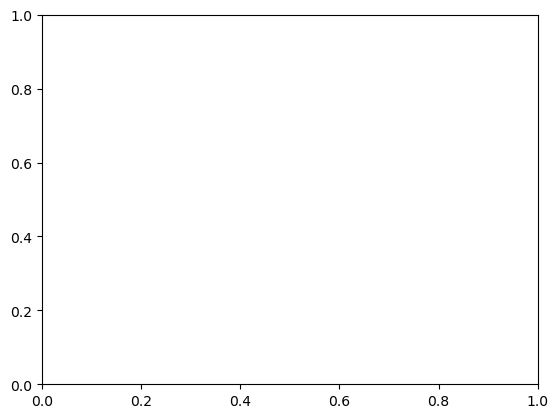

In [26]:
fig,ax = plt.subplots()
im = ax.imshow(T.cpu().detach().numpy().reshape(200,200),cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Temp_xy_Proposal.svg',format = 'svg',bbox_inches = 't

ValueError: cannot reshape array of size 10000 into shape (200,200)

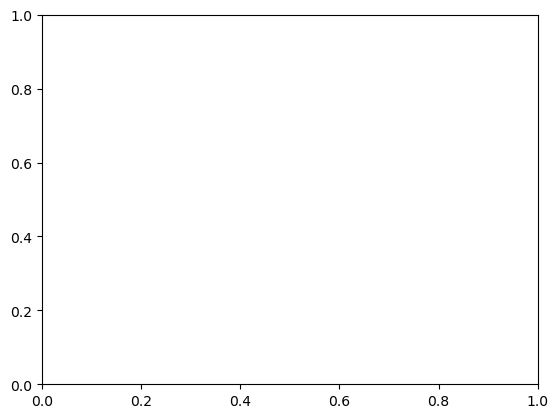

In [27]:
fig,ax = plt.subplots()
im = ax.imshow((eps_e/2).reshape(200,200),cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Eps_xy_QSR.svg',format = 'svg',bbox_inches = 'tight')

Text(0, 0.5, '$z$ (mm)')

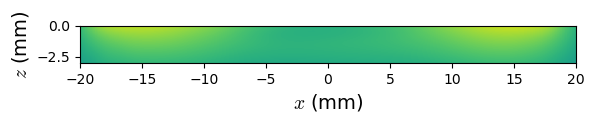

In [31]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(T.cpu().detach().numpy().reshape(50,200)),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
# plt.savefig('Eps_xz_QSR.svg',format = 'svg',bbox_inches = 'tight')

tensor([763.8500], grad_fn=<UnbindBackward0>)

In [ ]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(eps_e.cpu().detach().numpy().reshape(50,200)),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)

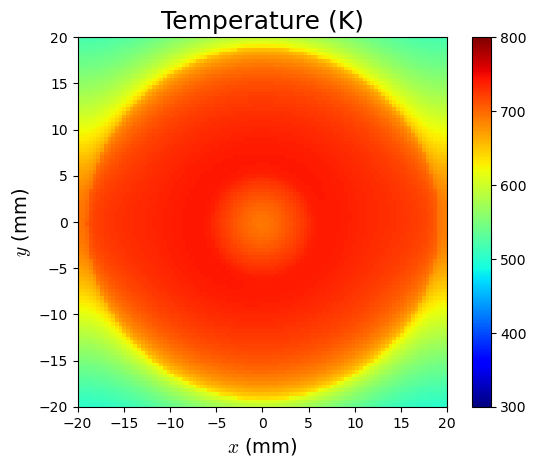

In [33]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(T_fvm[75:175,:,-1],cmap = 'jet',extent = [-20,20,-20,20],vmax = 800,vmin = 300)
fig.colorbar(im)
ax.set_title('Temperature (K)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

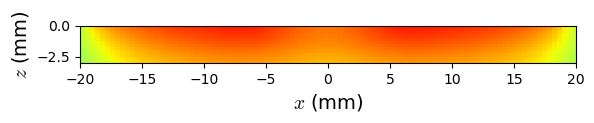

In [29]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(T_fvm[75:175,49,:])),cmap = 'jet',extent = [-20,20,-3,0],vmax = 800,vmin = 300)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_T_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')

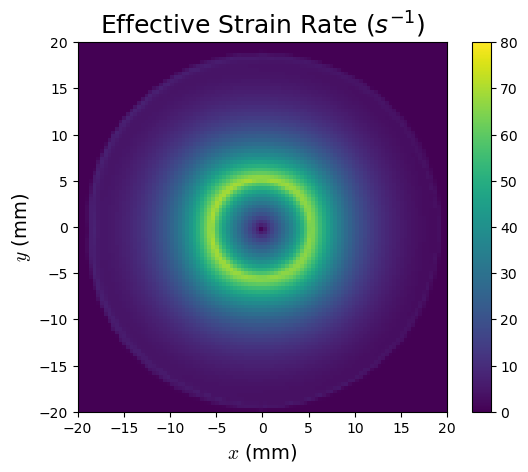

In [77]:
#FVM Plot
fig,ax = plt.subplots()
im = ax.imshow(eps_e_fvm[75:175,:,-1],cmap = 'viridis',extent = [-20,20,-20,20],vmax = 80,vmin = 0)
fig.colorbar(im)
ax.set_title('Effective Strain Rate ($s^{-1}$)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$y$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xy.svg',format = 'svg',bbox_inches = 'tight')

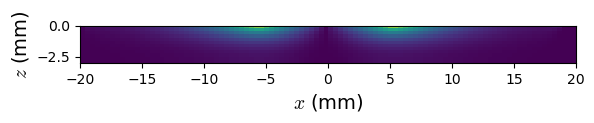

In [78]:
fig,ax = plt.subplots()
im = ax.imshow(np.flip(np.transpose(eps_e_fvm[75:175,49,:])),cmap = 'viridis',extent = [-20,20,-3,0],vmax = 80,vmin = 0)
# fig.colorbar(im)
# ax.set_title('Resultant Velocity (m/s)',fontsize = 18)
ax.set_xlabel('$x$ (mm)',math_fontfamily = 'cm',fontsize = 14)
ax.set_ylabel('$z$ (mm)',math_fontfamily = 'cm',fontsize = 14)
plt.savefig('FVM_eps_Exp_xz.svg',format = 'svg',bbox_inches = 'tight')